In [1]:
%pip install omegaconf
%pip install iopath
%pip install timm
%pip install decord
%pip install webdataset
%pip install einops
%pip install wandb
%pip install gradio
%pip install torchshow
%pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import argparse
import os
import random
import json
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torchshow as ts
from timechat.common.config import Config
from timechat.common.dist_utils import get_rank
from timechat.common.registry import registry
from timechat.conversation.conversation_video import Chat, Conversation, default_conversation,SeparatorStyle, conv_llava_llama_2
import decord
import cv2
import time
import subprocess
from decord import VideoReader
from timechat.processors.video_processor import ToTHWC, ToUint8, load_video
decord.bridge.set_bridge('torch')

# imports modules for registration
from timechat.datasets.builders import *
from timechat.models import *
from timechat.processors import *
from timechat.runners import *
from timechat.tasks import *

import random as rnd
from transformers import StoppingCriteria, StoppingCriteriaList
from PIL import Image
import gradio as gr

/opt/conda/envs/timechat/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def parse_args():
    parser = argparse.ArgumentParser(description="Demo")
    parser.add_argument("--cfg-path", default='eval_configs/timechat.yaml', help="path to configuration file.")
    parser.add_argument("--gpu-id", type=int, default=0, help="specify the gpu to load the model.")
    parser.add_argument("--num-beams", type=int, default=1)
    parser.add_argument("--temperature", type=float, default=1.0)
    parser.add_argument("--text-query", default="What is he doing?", help="question the video")
    parser.add_argument("--video-path", default='examples/padthai_2.mp4', help="path to video file.")
    parser.add_argument(
        "--options",
        nargs="+",
        help="override some settings in the used config, the key-value pair "
        "in xxx=yyy format will be merged into config file (deprecate), "
        "change to --cfg-options instead.",
    )
    args = parser.parse_args(args=[])
    return args

In [5]:
print('Initializing Chat')
args = parse_args()
cfg = Config(args)

DIR="ckpt/timechat"
MODEL_DIR=f"{DIR}/timechat_7b.pth"

model_config = cfg.model_cfg
model_config.device_8bit = args.gpu_id
model_config.ckpt = MODEL_DIR
model_cls = registry.get_model_class(model_config.arch)
model = model_cls.from_config(model_config).to('cuda:{}'.format(args.gpu_id))
model.eval()

vis_processor_cfg = cfg.datasets_cfg.webvid.vis_processor.train
vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)

Initializing Chat
Loading VIT


INFO:root:freeze vision encoder


Loading VIT Done
Loading Q-Former
use text input for Qformer


INFO:root:load checkpoint from ckpt/instruct-blip/instruct_blip_vicuna7b_trimmed.pth
INFO:root:freeze Qformer
INFO:root:Loading Q-Former Done
INFO:root:Loading LLAMA Tokenizer
Using pad_token, but it is not set yet.
INFO:root:Loading LLAMA Model
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]
INFO:root:use gradient checkpointing for LLAMA
INFO:root:Loading LLAMA Done
INFO:root:Using LORA
INFO:root:Loading LLAMA proj
INFO:root:LLAMA proj is frozen
INFO:root:Loading llama_proj Done


trainable params: 0 || all params: 6,771,970,048 || trainable%: 0.0


INFO:root:video_Qformer is frozen


Load first Checkpoint: ckpt/timechat/timechat_7b.pth


In [6]:
chat = Chat(model, vis_processor, device='cuda:{}'.format(args.gpu_id))
print('Initialization Finished')

Initialization Finished


In [7]:
%pip install ffmpeg-python

Note: you may need to restart the kernel to use updated packages.


torch.Size([3, 32, 720, 1280])


/opt/conda/envs/timechat/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Generate a summarized version of the video, focusing on extracting key frames that best represent the overall narrative. The output should be a list of timestamps in seconds and their corresponding salient scores.
The emphasized frames are 16.0 - 45.0 seconds, 72.0 - 87.0 seconds, 127.0 - 132.0 seconds, 180.0 - 190.0 seconds, 256.0 - 261.0 seconds, 273.0 - 278.0 seconds, 293.0 - 296.0 seconds.


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

Segment 1: 7 (from 16.0 to 45.0) extracted to segmented_videos_slc_2/new/chicken/output_0.mp4


frame= 2548 fps=988 q=31.0 Lsize=    9663kB time=00:01:25.00 bitrate= 931.2kbits/s speed=  33x    
video:8256kB audio:1335kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.756596%
[aac @ 0x55a58c9c1c00] Qavg: 206.865


Segment 2: 1 (from 2.0 to 87.0) extracted to segmented_videos_slc_2/new/chicken/output_1.mp4


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

Segment 3: 1 (from 27.0 to 132.0) extracted to segmented_videos_slc_2/new/chicken/output_2.mp4


frame= 3297 fps=945 q=31.0 Lsize=   15306kB time=00:01:50.01 bitrate=1139.7kbits/s speed=31.5x    
video:13488kB audio:1724kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.614500%
[aac @ 0x55c96b99bc00] Qavg: 220.305
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil  

Segment 4: 2 (from 80.0 to 190.0) extracted to segmented_videos_slc_2/new/chicken/output_3.mp4


frame= 6144 fps=959 q=31.0 Lsize=   27274kB time=00:03:25.00 bitrate=1089.8kbits/s dup=1 drop=0 speed=  32x    
video:23884kB audio:3217kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.638021%
[aac @ 0x55a4ad95ec00] Qavg: 207.914
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame


Segment 5: 2 (from 56.0 to 261.0) extracted to segmented_videos_slc_2/new/chicken/output_4.mp4


frame= 6144 fps=997 q=31.0 Lsize=   27245kB time=00:03:25.00 bitrate=1088.7kbits/s speed=33.3x    
video:23856kB audio:3216kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.638688%
[aac @ 0x5651122b4c00] Qavg: 208.528


Segment 6: 2 (from 73.0 to 278.0) extracted to segmented_videos_slc_2/new/chicken/output_5.mp4
torch.Size([3, 32, 224, 398])


/opt/conda/envs/timechat/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Generate a summarized version of the video, focusing on extracting key frames that best represent the overall narrative. The output should be a list of timestamps in seconds and their corresponding salient scores.
0.0 - 16.3 seconds, A man is standing outdoors on a deck with a grill.  16.3 - 67.7 seconds, He puts sausage on the grill, seasoning it.  67.7 - 182.4 seconds, He also puts bacon on the grill.  182.4 - 209.8 seconds, He flips the sausage, turning it.
Segment 1: A man is standing outdoors on a deck with a grill. (from 0.0 to 16.3) extracted to segmented_videos_slc_2/new/hotdog/output_0.mp4


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

Segment 2: He puts sausage on the grill, seasoning it. (from 16.3 to 67.7) extracted to segmented_videos_slc_2/new/hotdog/output_1.mp4


frame=  688 fps=0.0 q=5.7 Lsize=    2917kB time=00:01:54.66 bitrate= 208.4kbits/s speed= 547x    
video:2914kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.132696%
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec  

Segment 3: He also puts bacon on the grill. (from 67.7 to 182.4) extracted to segmented_videos_slc_2/new/hotdog/output_2.mp4


frame=  164 fps=0.0 q=6.4 Lsize=     829kB time=00:00:27.33 bitrate= 248.4kbits/s speed= 441x    
video:827kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.194428%


Segment 4: He flips the sausage, turning it. (from 182.4 to 209.8) extracted to segmented_videos_slc_2/new/hotdog/output_3.mp4
torch.Size([3, 32, 720, 1280])


/opt/conda/envs/timechat/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Generate a summarized version of the video, focusing on extracting key frames that best represent the overall narrative. The output should be a list of timestamps in seconds and their corresponding salient scores.
The highlight timestamps are in the 1.3, 13.1, 34.1, 45.8, 73.6, 84.6, 114.9, 177.6, 209.9, 224.5, 265.2, 270.9, 286.5, 302.2, 305.2, 311.0, 315.0, 324.5, 348.8, 363.5, 370.6, 378.0, 386.2, 400.6, 404.4, 410.0, 418.3, 425.5, 430.8, 446.8, 456.7, 468.3, 475.0, 483.8, 493.0, 502.2, 515.8, 523.7, 529.5, 534.3, 545.2, 555.0, 559.
torch.Size([3, 32, 720, 1280])
Generate a summarized version of the video, focusing on extracting key frames that best represent the overall narrative. The output should be a list of timestamps in seconds and their corresponding salient scores.
0.0 - 13.1 seconds, A man is seen standing with his hand out in front of him and leads into a person wearing gloves pulling something from a plastic mannequin.  16.4 - 65.4 seconds, A man is then seen pulling on s

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

Segment 1: A man is seen standing with his hand out in front of him and leads into a person wearing gloves pulling something from a plastic mannequin. (from 0.0 to 13.1) extracted to segmented_videos_slc_2/new/takeblood/output_0.mp4


frame= 1225 fps=920 q=31.0 Lsize=    4963kB time=00:00:49.01 bitrate= 829.5kbits/s speed=36.8x    
video:4163kB audio:768kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.658041%
[aac @ 0x555a1090e180] Qavg: 242.691
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil    

Segment 2: A man is then seen pulling on strings on a human body with his other hand behind him. (from 16.4 to 65.4) extracted to segmented_videos_slc_2/new/takeblood/output_1.mp4


frame= 3635 fps=944 q=31.0 Lsize=   13935kB time=00:02:25.40 bitrate= 785.1kbits/s speed=37.8x    
video:11558kB audio:2284kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.674484%
[aac @ 0x558cb1b74180] Qavg: 261.663


Segment 3: The man continues pulling on the strings and leads into him using a white rag to clean a stick off. (from 56.8 to 202.2) extracted to segmented_videos_slc_2/new/takeblood/output_2.mp4
torch.Size([3, 32, 360, 640])


/opt/conda/envs/timechat/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Generate a summarized version of the video, focusing on extracting key frames that best represent the overall narrative. The output should be a list of timestamps in seconds and their corresponding salient scores.
The highlight timestamps are in the 0.0, 4.9, 16.5, 17.0, 33.5, 36.3, 47.3, 63.5, 72.5, 74.1, 76.0, 76.6, 77.2, 84.1, 84.6, 126.1, 135.0, 137.0, 141.0, 142.2, 144.6, 147.5, 152.3, 175.4, 185.3, 186.1, 190.0, 192.2, 195.6, 205.8, 208.4, 210.2, 222.2, 223.2, 224.2, 225.2, 226.0, 226.2, 227.0, 227.1, 231.2, 233.2, 235.0, 238.2,
torch.Size([3, 32, 360, 640])
Generate a summarized version of the video, focusing on extracting key frames that best represent the overall narrative. The output should be a list of timestamps in seconds and their corresponding salient scores.
The emphasized frames are 14.8 - 21.0 seconds, 37.9 - 52.0 seconds, 93.1 - 103.2 seconds, 135.8 - 139.4 seconds, 161.3 - 164.4 seconds, 167.8 - 173.4 seconds, 177.1 - 180.5 seconds, 182.6 - 187.0 seconds, 190.7 - 19

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

Segment 1: 3 (from 14.8 to 21.0) extracted to segmented_videos_slc_2/new/woundpack/output_0.mp4


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

Segment 2: 9 (from 7.9 to 52.0) extracted to segmented_videos_slc_2/new/woundpack/output_1.mp4


frame= 2400 fps=1298 q=16.9 Lsize=    4293kB time=00:01:40.10 bitrate= 351.3kbits/s dup=1 drop=0 speed=54.1x    
video:2658kB audio:1576kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.386386%
[aac @ 0x55b389743000] Qavg: 166.107
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame


Segment 3: 1 (from 3.1 to 103.2) extracted to segmented_videos_slc_2/new/woundpack/output_2.mp4


frame= 2484 fps=1271 q=31.0 Lsize=    4502kB time=00:01:43.60 bitrate= 356.0kbits/s dup=1 drop=0 speed=  53x    
video:2811kB audio:1631kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.366671%
[aac @ 0x55c6933d6000] Qavg: 168.279
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame


Segment 4: 1 (from 35.8 to 139.4) extracted to segmented_videos_slc_2/new/woundpack/output_3.mp4


frame= 2472 fps=1283 q=21.8 Lsize=    4429kB time=00:01:43.11 bitrate= 351.8kbits/s speed=53.5x    
video:2743kB audio:1625kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.383130%
[aac @ 0x5630caa57000] Qavg: 166.947
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil  

Segment 5: 1 (from 61.3 to 164.4) extracted to segmented_videos_slc_2/new/woundpack/output_4.mp4


frame= 2532 fps=1294 q=31.0 Lsize=    4549kB time=00:01:45.60 bitrate= 352.8kbits/s speed=  54x    
video:2825kB audio:1661kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.378519%
[aac @ 0x562da1740000] Qavg: 168.597
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil  

Segment 6: 1 (from 67.8 to 173.4) extracted to segmented_videos_slc_2/new/woundpack/output_5.mp4


frame= 2480 fps=1249 q=17.9 Lsize=    4454kB time=00:01:43.42 bitrate= 352.8kbits/s speed=52.1x    
video:2767kB audio:1627kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.379297%
[aac @ 0x558f354a1000] Qavg: 185.148
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil  

Segment 7: 1 (from 77.1 to 180.5) extracted to segmented_videos_slc_2/new/woundpack/output_6.mp4


frame= 2504 fps=1288 q=20.1 Lsize=    4481kB time=00:01:44.42 bitrate= 351.6kbits/s dup=1 drop=0 speed=53.7x    
video:2776kB audio:1644kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.384019%
[aac @ 0x55f9fb01d000] Qavg: 185.943
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame


Segment 8: 1 (from 82.6 to 187.0) extracted to segmented_videos_slc_2/new/woundpack/output_7.mp4


frame= 2472 fps=1265 q=19.8 Lsize=    4415kB time=00:01:43.11 bitrate= 350.7kbits/s speed=52.8x    
video:2729kB audio:1625kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.387518%
[aac @ 0x55f9371e1000] Qavg: 184.405
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil  

Segment 9: 2 (from 90.7 to 193.8) extracted to segmented_videos_slc_2/new/woundpack/output_8.mp4


frame= 5009 fps=1289 q=14.8 Lsize=    8722kB time=00:03:28.90 bitrate= 342.0kbits/s dup=1 drop=0 speed=53.8x    
video:5311kB audio:3290kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.405755%
[aac @ 0x5636de9d3000] Qavg: 169.170
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame


Segment 10: 2 (from 1.6 to 210.5) extracted to segmented_videos_slc_2/new/woundpack/output_9.mp4


frame= 4827 fps=1308 q=18.4 Lsize=    8408kB time=00:03:21.31 bitrate= 342.2kbits/s speed=54.6x    
video:5123kB audio:3169kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.405807%
[aac @ 0x559cdb869000] Qavg: 167.710


Segment 11: 2 (from 14.3 to 215.6) extracted to segmented_videos_slc_2/new/woundpack/output_10.mp4


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

Segment 12: 2 (from 20.6 to 226.1) extracted to segmented_videos_slc_2/new/woundpack/output_11.mp4


frame= 4899 fps=1272 q=31.0 Lsize=    8562kB time=00:03:24.31 bitrate= 343.3kbits/s dup=1 drop=0 speed=53.1x    
video:5226kB audio:3218kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.400748%
[aac @ 0x558ea094c000] Qavg: 168.290
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame


Segment 13: 2 (from 31.0 to 235.3) extracted to segmented_videos_slc_2/new/woundpack/output_12.mp4


frame= 4839 fps=1278 q=31.0 Lsize=    8517kB time=00:03:21.80 bitrate= 345.7kbits/s dup=1 drop=0 speed=53.3x    
video:5223kB audio:3177kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.390880%
[aac @ 0x557a7b2a7000] Qavg: 168.645
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame


Segment 14: 2 (from 39.6 to 241.4) extracted to segmented_videos_slc_2/new/woundpack/output_13.mp4


frame= 4877 fps=1289 q=31.0 Lsize=    8616kB time=00:03:23.40 bitrate= 347.0kbits/s speed=53.8x    
video:5296kB audio:3202kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.385734%
[aac @ 0x55ca0c618000] Qavg: 168.938
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil  

Segment 15: 2 (from 47.0 to 250.4) extracted to segmented_videos_slc_2/new/woundpack/output_14.mp4


frame= 4875 fps=1293 q=31.0 Lsize=    8644kB time=00:03:23.31 bitrate= 348.3kbits/s dup=1 drop=0 speed=53.9x    
video:5326kB audio:3200kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.380354%
[aac @ 0x557680588000] Qavg: 169.216
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame


Segment 16: 2 (from 58.1 to 261.4) extracted to segmented_videos_slc_2/new/woundpack/output_15.mp4


frame= 4839 fps=1272 q=31.0 Lsize=    8570kB time=00:03:21.80 bitrate= 347.9kbits/s speed=53.1x    
video:5278kB audio:3176kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.382071%
[aac @ 0x563e5293b000] Qavg: 169.298
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil  

Segment 17: 2 (from 64.1 to 265.9) extracted to segmented_videos_slc_2/new/woundpack/output_16.mp4


frame= 4856 fps=1297 q=31.0 Lsize=    8604kB time=00:03:22.50 bitrate= 348.1kbits/s speed=54.1x    
video:5301kB audio:3185kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.381607%
[aac @ 0x55bedf19a000] Qavg: 169.933


Segment 18: 2 (from 68.1 to 270.6) extracted to segmented_videos_slc_2/new/woundpack/output_17.mp4
torch.Size([3, 32, 720, 1280])


/opt/conda/envs/timechat/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Generate a summarized version of the video, focusing on extracting key frames that best represent the overall narrative. The output should be a list of timestamps in seconds and their corresponding salient scores.
The highlights of the video are in 8.0 - 13.0 seconds, 65.0 - 69.0 seconds, 75.0 - 85.0 seconds, 115.0 - 123.0 seconds, 134.0 - 137.0 seconds, 142.0 - 144.0 seconds, 160.0 - 165.0 seconds, 170.0 - 175.0 seconds, 190.0 - 192.0 seconds, 200.0 - 204.0 seconds, 220.0 - 221.0 seconds, 227.0 - 229.0 seconds.


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

Segment 1: 6 (from 8.0 to 13.0) extracted to segmented_videos_slc_2/new/padthai_2/output_0.mp4


frame= 1919 fps=910 q=31.0 Lsize=   10153kB time=00:01:04.01 bitrate=1299.3kbits/s speed=30.4x    
video:9107kB audio:991kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.544902%
[aac @ 0x5583d651f3c0] Qavg: 3659.804


Segment 2: 7 (from 5.0 to 69.0) extracted to segmented_videos_slc_2/new/padthai_2/output_1.mp4


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

Segment 3: 1 (from 5.0 to 85.0) extracted to segmented_videos_slc_2/new/padthai_2/output_2.mp4


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

Segment 4: 1 (from 15.0 to 123.0) extracted to segmented_videos_slc_2/new/padthai_2/output_3.mp4


Output #0, mp4, to 'segmented_videos_slc_2/new/padthai_2/output_4.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: isommp42
    encoder         : Lavf58.45.100
    Stream #0:0(und): Video: mpeg4 (mp4v / 0x7634706D), yuv420p, 1280x720 [SAR 1:1 DAR 16:9], q=2-31, 200 kb/s, 29.97 fps, 30k tbn, 29.97 tbc (default)
    Metadata:
      creation_time   : 2023-09-20T14:58:28.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 09/20/2023.
      encoder         : Lavc58.91.100 mpeg4
    Side data:
      cpb: bitrate max/min/avg: 0/0/200000 buffer size: 0 vbv_delay: N/A
    Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 128 kb/s (default)
    Metadata:
      creation_time   : 2023-09-20T14:58:28.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 09/20/2023.
      encoder         : Lavc58.91.100 aac
frame= 3087 fps=909 q=31.0 Lsize=   17755kB time=00:01:43.00 bi

Segment 5: 1 (from 34.0 to 137.0) extracted to segmented_videos_slc_2/new/padthai_2/output_4.mp4


frame= 3057 fps=908 q=31.0 Lsize=   18408kB time=00:01:42.00 bitrate=1478.3kbits/s speed=30.3x    
video:16722kB audio:1599kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.473716%
[aac @ 0x558801ee73c0] Qavg: 2257.193
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil 

Segment 6: 1 (from 42.0 to 144.0) extracted to segmented_videos_slc_2/new/padthai_2/output_5.mp4


frame= 3147 fps=892 q=31.0 Lsize=   20042kB time=00:01:45.00 bitrate=1563.6kbits/s dup=1 drop=0 speed=29.8x    
video:18305kB audio:1647kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.447482%
[aac @ 0x55ae2c4933c0] Qavg: 2540.790
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame

Segment 7: 1 (from 60.0 to 165.0) extracted to segmented_videos_slc_2/new/padthai_2/output_6.mp4


Output #0, mp4, to 'segmented_videos_slc_2/new/padthai_2/output_7.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: isommp42
    encoder         : Lavf58.45.100
    Stream #0:0(und): Video: mpeg4 (mp4v / 0x7634706D), yuv420p, 1280x720 [SAR 1:1 DAR 16:9], q=2-31, 200 kb/s, 29.97 fps, 30k tbn, 29.97 tbc (default)
    Metadata:
      creation_time   : 2023-09-20T14:58:28.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 09/20/2023.
      encoder         : Lavc58.91.100 mpeg4
    Side data:
      cpb: bitrate max/min/avg: 0/0/200000 buffer size: 0 vbv_delay: N/A
    Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 128 kb/s (default)
    Metadata:
      creation_time   : 2023-09-20T14:58:28.000000Z
      handler_name    : ISO Media file produced by Google Inc. Created on: 09/20/2023.
      encoder         : Lavc58.91.100 aac
frame= 3147 fps=897 q=31.0 Lsize=   20156kB time=00:01:45.00 bi

Segment 8: 1 (from 70.0 to 175.0) extracted to segmented_videos_slc_2/new/padthai_2/output_7.mp4


frame= 3057 fps=909 q=31.0 Lsize=   19911kB time=00:01:42.00 bitrate=1599.0kbits/s dup=1 drop=0 speed=30.3x    
video:18219kB audio:1605kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.437782%
[aac @ 0x55badc8523c0] Qavg: 1757.350
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame

Segment 9: 2 (from 90.0 to 192.0) extracted to segmented_videos_slc_2/new/padthai_2/output_8.mp4


frame= 6114 fps=921 q=31.0 Lsize=   35614kB time=00:03:24.01 bitrate=1430.1kbits/s speed=30.7x    
video:32252kB audio:3190kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.485538%
[aac @ 0x555614b3d3c0] Qavg: 2679.214


Segment 10: 2 (from 0.0 to 204.0) extracted to segmented_videos_slc_2/new/padthai_2/output_9.mp4


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

Segment 11: 2 (from 20.0 to 221.0) extracted to segmented_videos_slc_2/new/padthai_2/output_10.mp4


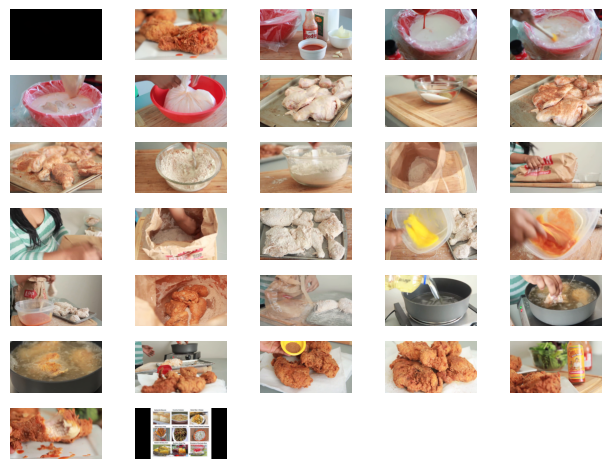

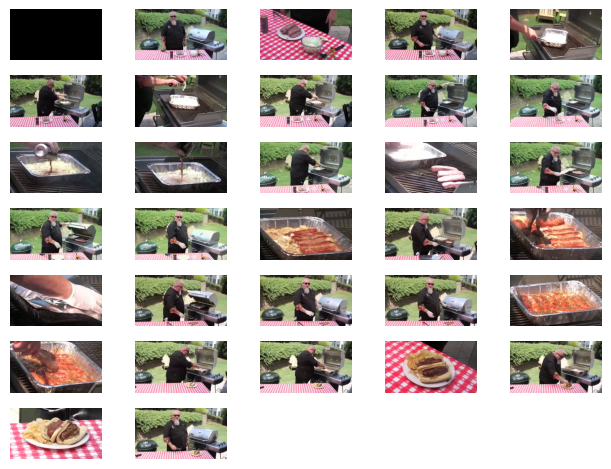

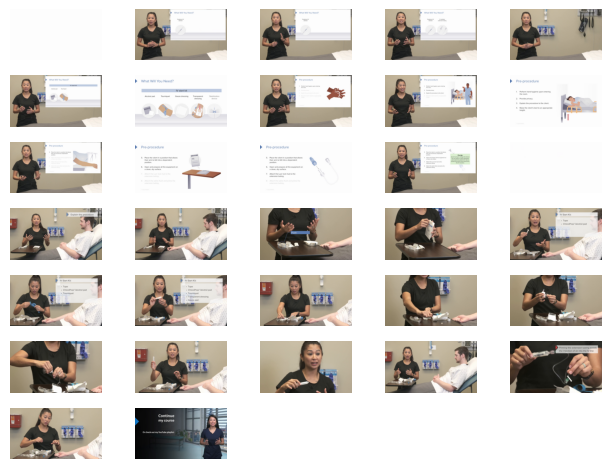

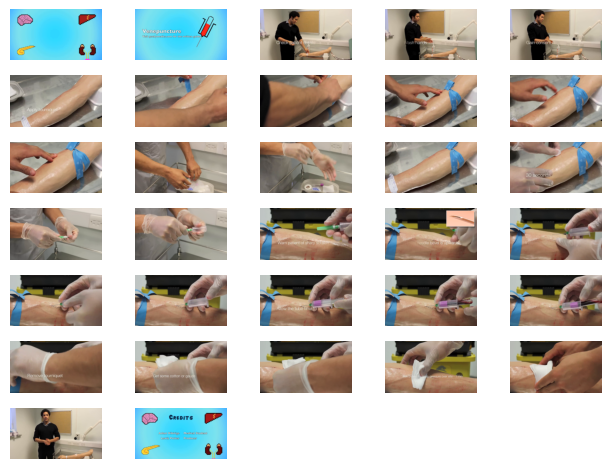

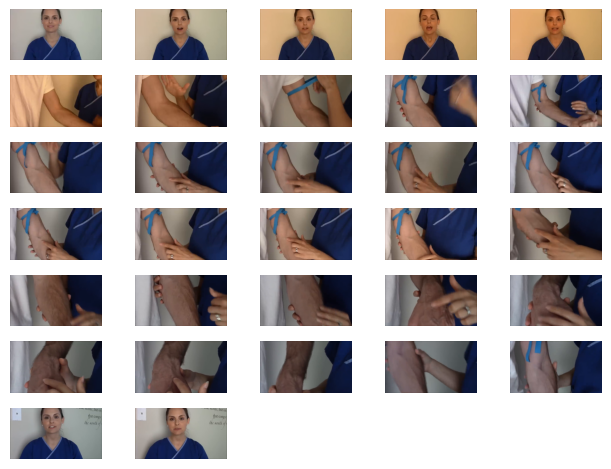

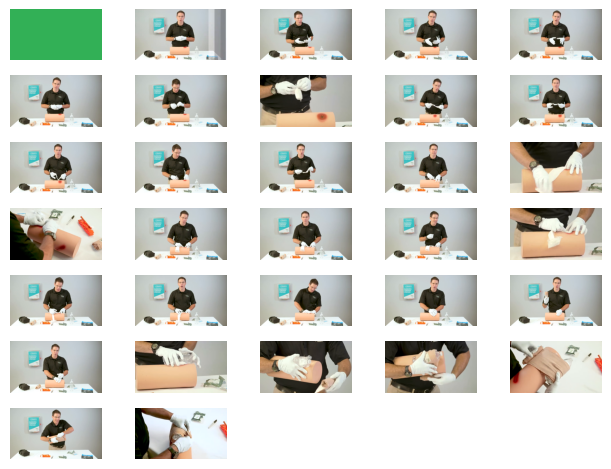

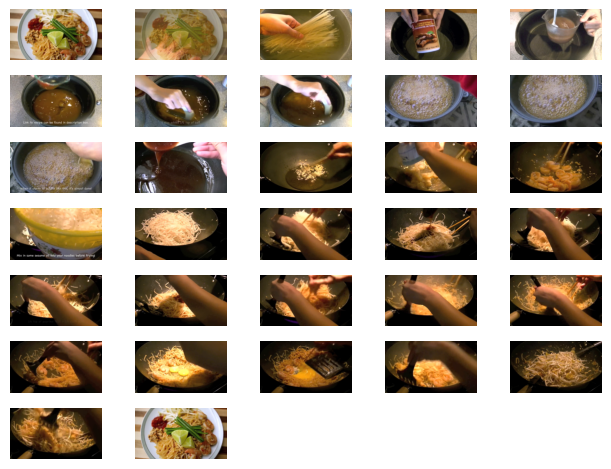

In [9]:
import re
import ffmpeg
import os

def extract_segment(input_file, output_file, start_time, end_time):
    (
        ffmpeg
        .input(input_file, ss=start_time)
        .output(output_file, to=end_time-start_time)
        .run()
    )

def parse_timestamps(llm_message):
    segments = []
    for match in re.finditer(r"(\d+\.\d+) - (\d+\.\d+) seconds, (.+?)(?=(?:\s*\d+\.\d+ -)|$)", llm_message):
        start_time = float(match.group(1))
        end_time = float(match.group(2))
        description = match.group(3).strip()
        segments.append((start_time, end_time, description))
    return segments

def extract_segments(input_file, llm_message):
    segments = parse_timestamps(llm_message)
    dvc_prompt_folder = "segmented_videos"
    highlight_prompt_folder = "segmented_videos_highlight"
    slc_prompt_folder = "segmented_videos_slc_2/new"
    summarization_prompt_folder = "segmented_videos_summ"
    output_folder = os.path.join(slc_prompt_folder, os.path.splitext(os.path.basename(input_file))[0])
    os.makedirs(output_folder, exist_ok=True)
    summary_file = os.path.join(output_folder, "segmentsummary.txt")
    with open(summary_file, "w") as f:
        for idx, (start_time, end_time, description) in enumerate(segments):
            output_file = os.path.join(output_folder, f"output_{idx}.mp4")
            extract_segment(input_file, output_file, start_time, end_time)
            print(f"Segment {idx+1}: {description} (from {start_time} to {end_time}) extracted to {output_file}")
            f.write(f"Segment {idx+1}: {description} (from {start_time} to {end_time}) extracted to {output_file}\n")

input_folder = 'examples'
youcook_prompt_dvc = "You are given a cooking video from the YouCook2 dataset. Please watch the video and extract a maximum of 10 significant cooking steps. For each step, determine the starting and ending times and provide a concise description. The format should be: 'start time - end time, brief step description'. For example, ' 90 - 102 seconds, spread margarine on two slices of white bread'."
highlight_prompt = "Localize a series of activity events in the video, output the start and end timestamp for each event, and describe each event with sentences. The output format of each predicted event should be like: 'start - end seconds, event description'. A specific example is : ' 90 - 102 seconds, spread margarine on two slices of white bread in the video'."
slc_prompt = "Identify and mark the video segments corresponding to a series of actions or steps, specifying the timestamps and describing the steps."
summarization_prompt = "Generate a summarized version of the video, focusing on extracting key frames that best represent the overall narrative. The output should be a list of timestamps in seconds and their corresponding salient scores."
for filename in os.listdir(input_folder):
    if filename.endswith(".mp4"):
        video_path = os.path.join(input_folder, filename)

        video, _ = load_video(
            video_path=video_path,
            n_frms=32,
            sampling="uniform",
            return_msg=True
        )
        # video = vis_processor.transform(video)
        print(video.size())
        C, T, H, W = video.shape
        ts.show(video.transpose(0, 1))

        img_list = []
        chat_state = conv_llava_llama_2.copy()
        chat_state.system = "You are able to understand the visual content that the user provides. Follow the instructions carefully and explain your answers in detail."
        msg = chat.upload_video_without_audio(
            video_path=video_path,
            conv=chat_state,
            img_list=img_list,
            n_frms=96,
        )

        text_input = summarization_prompt
        print(text_input)

        chat.ask(text_input, chat_state)

        num_beams = args.num_beams
        temperature = args.temperature
        llm_message = chat.answer(conv=chat_state,
                                  img_list=img_list,
                                  num_beams=num_beams,
                                  temperature=temperature,
                                  max_new_tokens=300,
                                  max_length=2000)[0]

        print(llm_message)

        extract_segments(video_path, llm_message)


In [1]:
import os

# Create the output folder if it doesn't exist
dvc_prompt_folder = "segmented_videos"
highlight_prompt_folder = "segmented_videos_highlight"
slc_prompt_folder = "segmented_videos_slc_2"
summarization_prompt_folder = "segmented_videos_summ"
dvc_summaries = "segmented_summaries"
highlight_summaries = "segmented_summaries_highlight"
slc_summaries = "segmented_summaries_slc"
summ_summaries = "segmented_summaries_summ"

output_folder = slc_prompt_folder
summary_folder = slc_summaries
os.makedirs(summary_folder, exist_ok=True)

# Iterate through all clips in the segment_outputs folder
for folder_name in os.listdir(output_folder):
    folder_path = os.path.join(output_folder, folder_name)
    if os.path.isdir(folder_path):
        summary_subfolder = os.path.join(summary_folder, folder_name)
        os.makedirs(summary_subfolder, exist_ok=True)
        combined_summary_path = os.path.join(summary_subfolder, "combined_summary.txt")
        with open(combined_summary_path, "w") as combined_summary_file:
            for filename in os.listdir(folder_path):
                if filename.endswith(".mp4"):
                    clip_path = os.path.join(folder_path, filename)
                    summary_path = os.path.join(summary_subfolder, filename.replace(".mp4", ".txt"))

                    # Give a short and clear explanation of the subsequent video clip.
                    video, _ = load_video(
                        video_path=clip_path,
                        n_frms=32,
                        sampling="uniform",
                        return_msg=True
                    )
                    # video = vis_processor.transform(video)
                    print(video.size())
                    C, T, H, W = video.shape
                    ts.show(video.transpose(0, 1))

                    img_list = []
                    chat_state = conv_llava_llama_2.copy()
                    chat_state.system = "You are able to understand the visual content that the user provides. Follow the instructions carefully and explain your answers in detail."
                    msg = chat.upload_video_without_audio(
                        video_path=clip_path,
                        conv=chat_state,
                        img_list=img_list,
                        n_frms=96,
                    )

                    text_input2 = "Give a short and clear explanation of the subsequent video clip."
                    print(text_input2)

                    chat.ask(text_input2, chat_state)

                    num_beams = args.num_beams
                    temperature = args.temperature
                    llm_message = chat.answer(conv=chat_state,
                                              img_list=img_list,
                                              num_beams=num_beams,
                                              temperature=temperature,
                                              max_new_tokens=300,
                                              max_length=2000)[0]

                    print(llm_message)

                    # Save the message to a text file
                    with open(summary_path, "w") as f:
                        f.write(llm_message)

                    # Write the summary to the combined summary file
                    combined_summary_file.write(f"{filename}\n{llm_message}\n\n")


NameError: name 'load_video' is not defined

In [ ]:
def combine_segments(input_folder):
    for root, dirs, files in os.walk(input_folder):
        video_files = [file for file in files if file.endswith(".mp4")]
        if video_files:
            output_file = os.path.join(root, "combined_video.mp4")
            input_files = [os.path.join(root, file) for file in video_files]
            inputs = [ffmpeg.input(file) for file in input_files]

            (
                ffmpeg
                .concat(*inputs, v=1, a=0)
                .output(output_file)
                .run()
            )

input_folder = "segmented_videos_slc_2" # "segmented_videos_highlights"
combine_segments(input_folder)